# Setup enviorment

In [1]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algebra operations
import numpy as np

# Machine learning models and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import tensorflow.keras.backend as K

# Epiweek
from epiweeks import Week, Year

# Date
from datetime import date as convert_to_date

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
features1 = 'Tabular_data/precipitation_all.csv'
features2 = 'Tabular_data/temperature_all 2.csv'
labels = 'Tabular_data/dengue_tabular.csv'
MUNICIPALITY = 'Ibagué'

In [4]:
cities =  {
  "76001":	"Cali",
  "05001":	"Medellín",
  "50001":	"Villavicencio",
  "54001":	"Cúcuta",
  "73001":	"Ibagué",
  "68001":	"Bucaramanga",
  "05360":	"Itagüí",
  "08001":	"Barranquilla",
  "41001":	"Neiva",
  "23001":	"Montería"
}

# Read Data

In [5]:
def epiweek_from_date(image_date):
    date = image_date.split('-')
    
    # Get year as int
    year = ''.join(filter(str.isdigit, date[0]))
    year = int(year)
    
    # Get month as int
    month = ''.join(filter(str.isdigit, date[1]))
    month = int(month)
    
    # Get day as int
    day = ''.join(filter(str.isdigit, date[2]))
    day = int(day)
    
    # Get epiweek:
    date = convert_to_date(year, month, day)
    epiweek = str(Week.fromdate(date))
    epiweek = int(epiweek)
    
    return epiweek

In [6]:
def get_epiweek(name):
    
    # Get week
    week = name.split('/')[1]
    week = week.replace('w','')
    week = int(week)
    
    # Year
    year = name.split('/')[0]
    year = int(year)
    
    epiweek = Week(year, week)
    
    epiweek = str(epiweek)
    epiweek = int(epiweek)

    return epiweek

In [7]:
def read_labels(path, Municipality = None):
    df = pd.read_csv(path)
    if df.shape[1] > 678:
        df = pd.concat([df[['Municipality code', 'Municipality']], df.iloc[:,-676:]], axis=1)
        cols = df.iloc[:, 2:].columns
        new_cols = df.iloc[:, 2:].columns.to_series().apply(get_epiweek)
        df = df.rename(columns=dict(zip(cols, new_cols))) 
        
    if 'Label_CSV_All_Municipality' in path:
        # Get Columns
        df = df[['epiweek', 'Municipality code', 'Municipality', 'final_cases_label']]
        
        # change epiweek format
        df.epiweek = df.epiweek.apply(get_epiweek)
        
        # Remove duplicates
        df = df[df.duplicated(['epiweek','Municipality code','Municipality']) == False]
        
        # Replace Increase, decrease, stable to numerical:
        """
        - Stable = 0
        - Increased = 1 
        - Decreased = 2
        """
        df.final_cases_label = df.final_cases_label.replace({'Stable': 0, 'Increased': 1, 'Decreased': 2})
        
        # Create table
        df = df.pivot(index=['Municipality code', 'Municipality'], columns='epiweek', values='final_cases_label')

        # Reset Index:
        df = df.reset_index()
    
    if Municipality:
        df = df[df['Municipality'] == Municipality]
        df.drop(columns=['Municipality code'], inplace=True)
        df.rename(columns={'Municipality': 'Municipality Code'}, inplace=True)
    
        df = df.set_index('Municipality Code')
        df = df.T

        df.columns.name = None
        df.index.name = None
        
        df.columns = ['Cases']
    
    return df

### 1. Features

In [8]:
def get_code(MUNICIPALITY):
    for code, city in cities.items():
        if city == MUNICIPALITY:
            return code


In [9]:
code = get_code(MUNICIPALITY)

# Precipitation
for col in pd.read_csv(features1).columns:
    if code in col:
        column = col
        continue
        
precipitation_df = pd.read_csv(features1)[['LastDayWeek', column]]

# Temperature
for col in pd.read_csv(features2).columns:
    if code in col:
        column = col
        continue
        
temperature_df = pd.read_csv(features2)[['LastDayWeek', column]]

features_df = temperature_df.merge(precipitation_df, how='inner', on='LastDayWeek')

features_df['LastDayWeek'] = features_df['LastDayWeek'].apply(epiweek_from_date)

features_df = features_df.set_index('LastDayWeek')
features_df.index.name = None

features_df

,temperature_73001,precipitation_73001
200701,24.946964,0.645018
200702,24.264144,0.529253
200703,20.083175,2.710441
200704,23.460747,7.833754
200705,22.736030,0.000000
...,...,...
201949,22.111518,2.037096
201950,21.715790,4.301249
201951,19.738069,3.856570
201952,19.351382,4.000110


### 2. Labels

In [10]:
labels_df = read_labels(path=labels, Municipality=MUNICIPALITY)
labels_df = labels_df

# Data preparation

In [11]:
# Merge the two dataframes based on the date values
dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
dengue_df

,temperature_73001,precipitation_73001,Cases
200701,24.946964,0.645018,16
200702,24.264144,0.529253,15
200703,20.083175,2.710441,13
200704,23.460747,7.833754,12
200705,22.736030,0.000000,17
...,...,...,...
201948,22.189838,1.694186,149
201949,22.111518,2.037096,171
201950,21.715790,4.301249,175
201951,19.738069,3.856570,116


### Train Test split

In [12]:
def train_test_split(df, train_percentage = 80):
    # We need a sequence so we can't split randomly
    # To divide into Train and test we have to calculate the train percentage of the dataset:
    size = df.shape[0]
    split = int(size*(train_percentage/100))
    
    """ Train """
    # We will train with 1st percentage % of data and test with the rest
    train_df = df.iloc[:split,:] ## percentage % train
    
    """ Test """
    test_df = df.iloc[split:,:] # 100 - percentage % test
    
    print(f'The train shape is: {train_df.shape}')
    print(f'The test shape is: {test_df.shape}')
    
    return train_df, test_df

In [13]:
train_df, test_df = train_test_split(dengue_df, train_percentage = 80)

The train shape is: (540, 3)
The test shape is: (136, 3)


### Normalize features

In [14]:
# Normalize train data and create the scaler
def normalize_train_features(df, feature_range=(-1, 1), scaler=True):
    
    scalers = {}
    # For each column in the dataframe
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue
        
        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Generate a new scaler
        scaler = MinMaxScaler(feature_range=feature_range)
        # Fit the scaler just for that column
        scaled_column = scaler.fit_transform(values)
        # Add the scaled column to the dataframe
        scaled_column = np.reshape(scaled_column, len(scaled_column))
        df[column] = scaled_column
        
        # Save the scaler of the column
        scalers['scaler_' + column] = scaler
        
    print(f' Min values are: ')
    print(df.min())
    print(f' Max values are: ')
    print(df.max())
        
    return df, scalers


""" If you want to use the same scaler used in train, you can use this function"""
def normalize_test_features(df, scalers=None, scaler=True):
    
    if not scalers:
        raise TypeError("You should provide a list of scalers.")
        
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue
        
        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Take the scaler of that column
        scaler = scalers['scaler_' + column]
        # Scale values
        scaled_column = scaler.transform(values)
        scaled_column = np.reshape(scaled_column,len(scaled_column))
        # Add the scaled values to the df
        df[column] = scaled_column
        
    print(f' Min values are: ')
    print(df.min())
    print(f' Max values are: ')
    print(df.max())
        
    return df 

In [15]:
feature_range = (-1, 1)

# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)

#print(f'The scalers are: {scalers}')

train_df.head()

 Min values are: 
temperature_73001     -1.0
precipitation_73001   -1.0
Cases                 -1.0
dtype: float64
 Max values are: 
temperature_73001      1.0
precipitation_73001    1.0
Cases                  1.0
dtype: float64


,temperature_73001,precipitation_73001,Cases
200701,0.159359,-0.942369,-0.925072
200702,0.091213,-0.952713,-0.930836
200703,-0.326052,-0.757829,-0.942363
200704,0.011033,-0.300074,-0.948127
200705,-0.061294,-1.000000,-0.919308


In [16]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df.head()

 Min values are: 
temperature_73001     -0.876388
precipitation_73001   -1.000000
Cases                 -1.000000
dtype: float64
 Max values are: 
temperature_73001      0.590065
precipitation_73001    0.285061
Cases                  0.210375
dtype: float64


,temperature_73001,precipitation_73001,Cases
201721,-0.316573,-0.732136,-0.953890
201722,0.052298,-0.901894,-0.942363
201723,0.108699,-0.551715,-0.930836
201724,-0.302705,-0.323499,-0.907781
201725,-0.394908,-0.395549,-0.936599


### Prepare data for time series supervised learning (function to create sliding window)

In [17]:
# prepare data for time series

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, no_autoregressive=None):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        if no_autoregressive:
            cols.append(df.shift(i).iloc[:,:-1])
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars-1)]
        else:
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
# length of window
days = 10
no_autoregressive = True

# frame as supervised learning
train = series_to_supervised(train_df, n_in=days, no_autoregressive=no_autoregressive)
test = series_to_supervised(test_df, n_in=days, no_autoregressive=no_autoregressive)

DataFrame(train)

,var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),...,var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t),var3(t)
200711,0.159359,-0.942369,0.091213,-0.952713,-0.326052,-0.757829,0.011033,-0.300074,-0.061294,-1.000000,...,-0.785246,0.308142,-0.875494,0.262334,-0.940210,0.209776,-0.362179,0.436638,-0.508781,-0.850144
200712,0.091213,-0.952713,-0.326052,-0.757829,0.011033,-0.300074,-0.061294,-1.000000,0.110984,-1.000000,...,-0.875494,0.262334,-0.940210,0.209776,-0.362179,0.436638,-0.508781,0.742373,-0.634289,-0.942363
200713,-0.326052,-0.757829,0.011033,-0.300074,-0.061294,-1.000000,0.110984,-1.000000,-0.090387,-0.785246,...,-0.940210,0.209776,-0.362179,0.436638,-0.508781,0.742373,-0.634289,0.367135,-0.095417,-0.890490
200714,0.011033,-0.300074,-0.061294,-1.000000,0.110984,-1.000000,-0.090387,-0.785246,0.308142,-0.875494,...,-0.362179,0.436638,-0.508781,0.742373,-0.634289,0.367135,-0.095417,0.212988,-0.286917,-0.890490
200715,-0.061294,-1.000000,0.110984,-1.000000,-0.090387,-0.785246,0.308142,-0.875494,0.262334,-0.940210,...,-0.508781,0.742373,-0.634289,0.367135,-0.095417,0.212988,-0.286917,0.164600,-0.640739,-0.919308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201716,-0.186275,-0.924338,0.022260,-0.890100,0.005100,-0.636624,-0.288861,-0.570738,-0.578506,-0.197723,...,0.235784,-0.281186,0.005598,0.146265,-0.921407,0.111362,-0.185175,0.132612,-0.154426,-0.925072
201717,0.022260,-0.890100,0.005100,-0.636624,-0.288861,-0.570738,-0.578506,-0.197723,-0.165464,-0.032009,...,0.005598,0.146265,-0.921407,0.111362,-0.185175,0.132612,-0.154426,0.027562,-0.435145,-1.000000
201718,0.005100,-0.636624,-0.288861,-0.570738,-0.578506,-0.197723,-0.165464,-0.032009,-0.588111,0.235784,...,-0.921407,0.111362,-0.185175,0.132612,-0.154426,0.027562,-0.435145,-0.245723,0.415773,-0.965418
201719,-0.288861,-0.570738,-0.578506,-0.197723,-0.165464,-0.032009,-0.588111,0.235784,-0.281186,0.005598,...,-0.185175,0.132612,-0.154426,0.027562,-0.435145,-0.245723,0.415773,-1.000000,-0.249695,-0.965418


### Features and Labels Set

In [19]:
def features_labels_set(timeseries_data, original_df):
    
    """ Features """
    # We define the number of features as (Cases and media cloud)
    n_features = original_df.shape[1]

    # The features to train the model will be all except the values of the actual week 
    # We can't use other variables in week t because whe need to resample a a 3D Array
    features_set = DataFrame(timeseries_data.values[:,:-n_features])
    # Convert pandas data frame to np.array to reshape as 3D Array
    features_set = features_set.to_numpy()
    print(f'The shape of the features is {features_set.shape}')
    
    """ Labels """
    # We will use Covid cases in last week 
    labels_set = DataFrame(timeseries_data.values[:,-1])
    # Convert pandas data frame to np.array
    labels_set = labels_set.to_numpy()
    print(f'The shape of the labels is {labels_set.shape}')
    
    return features_set, labels_set, n_features

In [20]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df)

Train:
The shape of the features is (530, 20)
The shape of the labels is (530, 1)
Test:
The shape of the features is (126, 20)
The shape of the labels is (126, 1)


# Modeling

In [21]:
def reshape_tensor(train_X, test_X, n_features, no_autoregressive=None):
    print('The initial shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')
    
    # reshape input to be 3D [samples, timesteps, features]
    if no_autoregressive:
        train_X = train_X.reshape((train_X.shape[0], days, n_features-1))
        test_X = test_X.reshape((test_X.shape[0], days, n_features-1))
    
    else:
        train_X = train_X.reshape((train_X.shape[0], days, n_features))
        test_X = test_X.reshape((test_X.shape[0], days, n_features))
    
    print('-----------------------')
    print('The Final shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')
    
    return train_X, test_X

In [22]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, no_autoregressive)

The initial shapes are:
The train shape is (530, 20)
The test shape is (126, 20)
-----------------------
The Final shapes are:
The train shape is (530, 10, 2)
The test shape is (126, 10, 2)


# Define the Model

In [23]:
# Set Seed
#tf.random.set_seed(0)

def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape


def create_model():
    # design network
    model = Sequential()
    model.add(LSTM(120, dropout=0.1, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(240, dropout=0.1, input_shape=(train_X.shape[1], 120)))
    model.add(Dense(60))
    model.add(Dense(1))
    
    # Compile the model:
    opt = keras.optimizers.Adam()
    
    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='mape'),
        smape
    ]
    
    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model

### Train the model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

In [25]:
# fit network
def train_model(model, monitor, plot=None, epochs=50):
    if monitor:
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[monitor])
    else:
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    if plot:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.legend()
        plt.show()

# Test the model

In [26]:
from math import sqrt
from numpy import concatenate

def test_model(model, test_X, test_y, scaler, rnn = None):
    
    # If model is a classical machine learning model and test_X is a 3D tensor, then convert to 2D
    if not rnn and (len(test_X.shape) == 3):
        test_X = test_X.reshape((test_X.shape[0], -1))
    
    # do the prediction
    yhat = model.predict(test_X)
    
    # Invert scaling for forecast
    # Inverse Scaler
    
    # Predicted
    if not rnn:
        yhat = yhat.reshape(-1, 1)
        
    if not scaler:
        return yhat, test_y
    
    inv_yhat = scaler.inverse_transform(yhat)
    
    # Real:
    inv_y = scaler.inverse_transform(test_y)
    
    return inv_yhat, inv_y

### Mean Absolute Percentage Error (MAPE)

$$
MAPE = \displaystyle\frac{100\%}{n}\sum_{t=1}^{n}\left |\frac{x_i-y_i}{y_t}\right|
$$

MAPE has a problem if there are zeros in the test data, so other metrics can be explored

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Test MAPE: %.3f' % mape)
    return mape

### Symmetric Mean Absolute Percentage Error (sMAPE)

$$
sMAPE = \displaystyle\frac{100\%}{n}\sum_{t=1}^{n} \frac{|x_i-y_i|}{|x_i|+|y_t|}
$$

In [28]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    print('Test sMAPE: %.3f' % smape)
    return smape

### Mean Absoulte Error (MAE)
$$
RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(x_i-y_i)^{2}}
$$

In [29]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print('Test RMSE: %.3f' % rmse)
    return rmse

In [30]:
def plot_predictions(inv_y, inv_yhat, model_name = ''):
    data_predict = inv_yhat  ## predicted target cases
    dataY_plot = inv_y  ##  real test-target cases

    data_predict = data_predict.reshape(len(data_predict), 1)
    dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

    plt.plot(dataY_plot, label = 'actual')
    plt.plot(data_predict, label = 'predicted')
    plt.legend(loc="upper left")

    plt.suptitle(f'Time-Series Prediction with {model_name}')
    plt.show()

In [31]:
def evaluate(model, test_X, test_y, scaler):
    stored_results = {}
    
    inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=y_scaler, rnn = True)
    stored_results['mape'] = mean_absolute_percentage_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['smape'] = symmetric_mean_absolute_percentage_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['rmse'] = root_mean_squared_error(inv_y_lstm, inv_yhat_lstm)

    return stored_results

# Calculate Mean and SD

In [32]:
# With LSTM:
#print(f'The scalers are: {scalers.keys()}')
y_scaler = scalers['scaler_Cases']

def calculate_mean_std():
    
    metrics = {
        "rmse": [],
        "mape": [],
        "smape": []
    }
    
    for i in range(10):
        model = create_model()
        train_model(model=model, monitor=monitor)
        stored_results = evaluate(model, test_X, test_y, y_scaler)
        print(stored_results)
        
        for key in metrics.keys():
            metrics[key].append(stored_results[key])
            
    for key in metrics.keys():
        results = metrics[key]
        print(key, f": average={np.average(results):.3f}, std={np.std(results):.3f}")


In [33]:
calculate_mean_std()

Epoch 1/50
34/34 - 4s - loss: 0.2713 - rmse: 0.5209 - mape: 93.2488 - smape: 0.6955 - val_loss: 0.1730 - val_rmse: 0.4159 - val_mape: 404.1132 - val_smape: 0.3923
Epoch 2/50
34/34 - 0s - loss: 0.1519 - rmse: 0.3897 - mape: 93.4578 - smape: 0.4173 - val_loss: 0.1325 - val_rmse: 0.3640 - val_mape: 282.9704 - val_smape: 0.5216
Epoch 3/50
34/34 - 0s - loss: 0.1546 - rmse: 0.3931 - mape: 102.9024 - smape: 0.3608 - val_loss: 0.1379 - val_rmse: 0.3713 - val_mape: 262.9005 - val_smape: 0.5566
Epoch 4/50
34/34 - 0s - loss: 0.1392 - rmse: 0.3731 - mape: 106.3478 - smape: 0.3479 - val_loss: 0.1316 - val_rmse: 0.3627 - val_mape: 261.7047 - val_smape: 0.5440
Epoch 5/50
34/34 - 0s - loss: 0.1215 - rmse: 0.3485 - mape: 113.6013 - smape: 0.3444 - val_loss: 0.1284 - val_rmse: 0.3583 - val_mape: 263.9039 - val_smape: 0.5358
Epoch 6/50
34/34 - 0s - loss: 0.1170 - rmse: 0.3421 - mape: 114.8183 - smape: 0.3492 - val_loss: 0.1227 - val_rmse: 0.3503 - val_mape: 269.1487 - val_smape: 0.5188
Epoch 7/50
34/34 -

# Plot an example

Epoch 1/50
34/34 - 3s - loss: 0.2902 - rmse: 0.5387 - mape: 94.9268 - smape: 0.7223 - val_loss: 0.1623 - val_rmse: 0.4028 - val_mape: 392.0177 - val_smape: 0.3848
Epoch 2/50
34/34 - 0s - loss: 0.1593 - rmse: 0.3991 - mape: 91.0865 - smape: 0.4258 - val_loss: 0.1447 - val_rmse: 0.3804 - val_mape: 269.9615 - val_smape: 0.5652
Epoch 3/50
34/34 - 0s - loss: 0.1518 - rmse: 0.3896 - mape: 107.2691 - smape: 0.3528 - val_loss: 0.1430 - val_rmse: 0.3782 - val_mape: 258.9618 - val_smape: 0.5715
Epoch 4/50
34/34 - 0s - loss: 0.1281 - rmse: 0.3579 - mape: 112.6671 - smape: 0.3459 - val_loss: 0.1323 - val_rmse: 0.3637 - val_mape: 261.7338 - val_smape: 0.5450
Epoch 5/50
34/34 - 0s - loss: 0.1210 - rmse: 0.3478 - mape: 114.2002 - smape: 0.3507 - val_loss: 0.1269 - val_rmse: 0.3562 - val_mape: 265.8304 - val_smape: 0.5302
Epoch 6/50
34/34 - 0s - loss: 0.1178 - rmse: 0.3433 - mape: 114.7793 - smape: 0.3478 - val_loss: 0.1252 - val_rmse: 0.3539 - val_mape: 265.9966 - val_smape: 0.5271
Epoch 7/50
34/34 -

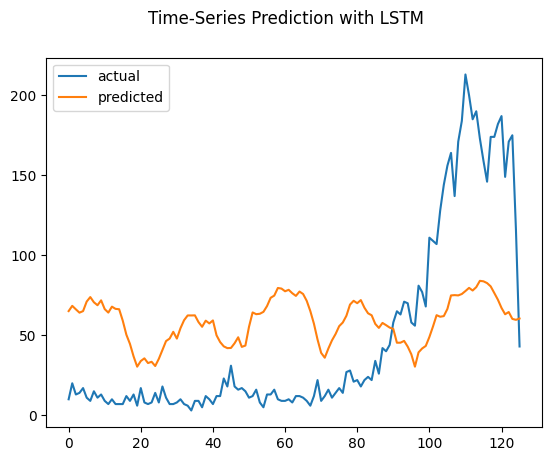

In [34]:
model = create_model()
train_model(model=model, monitor=monitor)
inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=y_scaler, rnn = True)
    
# LSTM
plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = 'LSTM')